In this notebook, we shall use a single-cell RNAseq data to estimate cell type proportions in spatial transcriptomics data.

## Datasets needed for tutorial

The datasets used in this tutorial are available as part the [DISSECT](https://github.com/robinredX/DISSECT/tutorials/data) repository. 

Sources:

The spatial RNAseq data is taken from 10x Genomics and for this tutorial, due to size limitations of GitHub, we will use a sampled dataset that contains part of the count object. The complete data can be downloaded at [this link](https://www.10xgenomics.com/datasets/mouse-brain-serial-section-2-sagittal-anterior-1-standard). 

The single-cell RNAseq data comes from Allen Brain Atlas and for this tutorial, we will use a sampled dataset. The complete count matrix can be downloaded at [this link](http://portal.brain-map.org/atlases-and-data/rnaseq). 

### A note on the supported formats

**(1) Spatial transcriptomics**

A h5ad compatible with Scanpy >=1.8.0. 

The gene IDs can be gene symbols, ENSEMBL etc. as long as same format is used for the scRNAseq data. 

The data should contain tissue images and spot coordinates as shown below:

In [1]:
import scanpy as sc
st_path = "data/spatial/V1_Mouse_Brain_Sagittal_Anterior_cortex.h5ad"
adata_vis = sc.read(st_path)
adata_vis

/home/robinkti/miniconda/envs/dissect_env_1/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 960 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Coordinates are stored in .obsm["spatial"] and images in .uns["spatial"]. We can check them as below.

In [2]:
av_samples = adata_vis.uns["spatial"].keys()
av_samples

dict_keys(['V1_Mouse_Brain_Sagittal_Anterior'])

This indicates, we have one visium sample.

In [3]:
sample_name = 'V1_Mouse_Brain_Sagittal_Anterior'
images = adata_vis.uns["spatial"][sample_name]["images"]
images["lowres"].shape, images["hires"].shape # Image arrays

((600, 600, 3), (1998, 2000, 3))

In [4]:
# Coordinates
adata_vis.obsm["spatial"]

array([[7950, 3163],
       [6917, 5678],
       [9257, 4241],
       ...,
       [5610, 3642],
       [5885, 4361],
       [6780, 5199]])

**(2) scRNAseq**

A h5ad compatible with Scanpy >=1.8.0.
Metadata included in .obs attribute as can be seen below:

In [5]:
import scanpy as sc
sc_path = "data/scRNAseq/mouseBrainAllenInstitute_sc_sampled.h5ad"
adata = sc.read(sc_path)
adata

AnnData object with n_obs × n_vars = 1404 × 34617
    obs: 'Celltype', 'n_counts'

From the metadata, we need names of cell type column and batch column (if any).

adata.X must contain raw counts. This can be checked by checking the maximum value which will be high integer value (>100).

In [6]:
adata.X.max()

559532.0

**The config paramaters area identical with the bulk transcriptomics. The only difference is how we simulate, which needs to be updated as we do below in the config["simulation_params"]["type"].**

## Import DISSECT module

In [3]:
import dissect

DISSECT can be configured with a config file available from the following command.

In [8]:
config = dissect.config

In [9]:
config

{'experiment_folder': '/home/user/experiment',
 'simulation_params': {'scdata': '/home/user/experiment/data.h5ad',
  'n_samples': None,
  'type': 'bulk',
  'celltype_col': 'celltype',
  'batch_col': None,
  'cells_per_sample': None,
  'downsample': None,
  'preprocess': None,
  'filter': {'min_genes': 200, 'min_cells': 3, 'mt_cutoff': 5, 'min_expr': 0},
  'concentration': None,
  'prop_sparse': 0.5,
  'generate_component_figures': True},
 'deconv_params': {'test_dataset': '../bulk.txt',
  'test_dataset_format': 'txt',
  'test_dataset_type': 'bulk',
  'duplicated': 'first',
  'normalize_simulated': 'cpm',
  'normalize_test': 'cpm',
  'var_cutoff': 0.1,
  'test_in_mix': None,
  'simulated': True,
  'sig_matrix': False,
  'mix': 'srm',
  'save_config': True,
  'network_params': {'n_hidden_layers': 4,
   'hidden_units': [512, 256, 128, 64],
   'hidden_activation': 'relu6',
   'output_activation': 'softmax',
   'loss': 'kldivergence',
   'n_steps': 5000,
   'lr': 1e-05,
   'batch_size': 64,

Description of each hyperparameter can be seen with the following function

In [4]:
dissect.config_info()

config = {

    "experiment_folder": "/home/user/experiment",  # Path to save outputs. Default: "/home/user/experiment"



    "simulation_params": { 

        "scdata": "/home/user/experiment/data.h5ad",  # Path to sc/snRNA-seq data, should be anndata

        "n_samples": None,  # Number of samples to generate. Default (None): 1000 times the number of celltypes,

        "type": "bulk", # bulk or st to simulate bulk and spatial transcriptomics respectively

        "celltype_col": "celltype",  # Name of the column corresponding to cell-type labels in adata.obs

        "batch_col": None,  # If more than one batches are present, name of the column corrsponding to batch labels in adata.obs

        "cells_per_sample": 500,  # Number of cells to sample to generate one sample.

        "downsample": None,  # If simulation_type is ST, a float is used to downsample counts. Default (None): No downsampling

        "preprocess": None, # Default (None) will no preprocess

        "filter": { 

In application cases, we need to make following changes to this config dictionary: specify paths to our single cell and bulk data, as well as name of the cell type and batch columns. Since for this data, we have no batch column, we only need cell type column, which for the above scRNAseq object is "cell_type". 

In case our bulk data already contains TPM counts, we can set config["normalize_test"] to None. By default (i.e. value=None), 
it performs CPM normalization

**Below, we describe how to make these changes and run the algorithm.**

## Set experiment folder

In this config, **experiment_folder** specifies a non-existing experiment directory where the results would be stored

In [10]:
config["experiment_folder"] # this prints the current folder

'/home/user/experiment'

In [11]:
# we will set it to "tutorial_bulkRNAseq"

config["experiment_folder"] = "tutorial_visium"

## Do simulation

**simulation_params** contain hyperparameters for simulations

We can specify the path to our single-cell data, the data type, our cell type column name, and the number of samples to simulate

In [12]:
config["simulation_params"]["scdata"] = "data/scRNAseq/mouseBrainAllenInstitute_sc_sampled.h5ad"
config["simulation_params"]["type"] = "st" # for spatial data
config["simulation_params"]["celltype_col"] = "Celltype"
config["simulation_params"]["n_samples"] = 1000 # By default, we simulate n (= 1000 times number of cell types) samples. Since, the number of cell types in this data is large (=23), for this tutorial, we shall simulate 6000 samples


In [13]:
# by default the single-cell data passes through following QC:
config["simulation_params"]["filter"]

{'min_genes': 200, 'min_cells': 3, 'mt_cutoff': 5, 'min_expr': 0}

**simulate** function from dissect can be used for simulation. It takes as input the above config.

Outputs

**(1) Simulated data**

Saves the simulated data as h5ad object in the folder simulations/simulated.h5ad within the config["experiment_folder"].

**(2) Plots**

The function also prints and saves the following if config["generate_component_figures"] is set to True (default):

(1) boxplots showing the proportions of cell types in the simulated data,

(2) a scatter plot showing principal components of the simulated data colored by cell type proportions, and

(3) a scatter plot showing principal components of the cell type-specific gene expression profiles for each sample.

Number of batches in single-cell data is 1. If this is incorrect, please specify name of the batch column as in the single-cell data object (.obs)


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.13it/s]


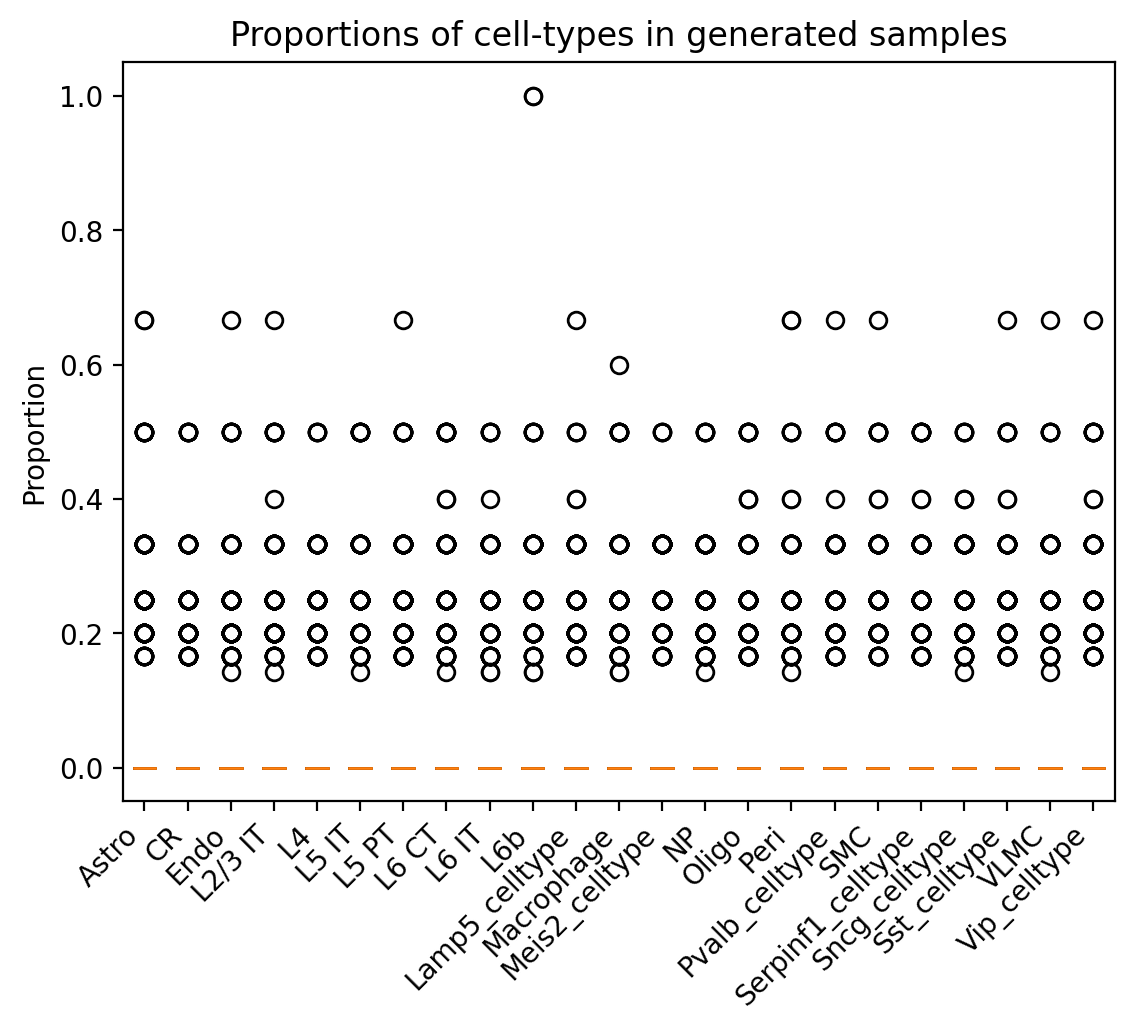

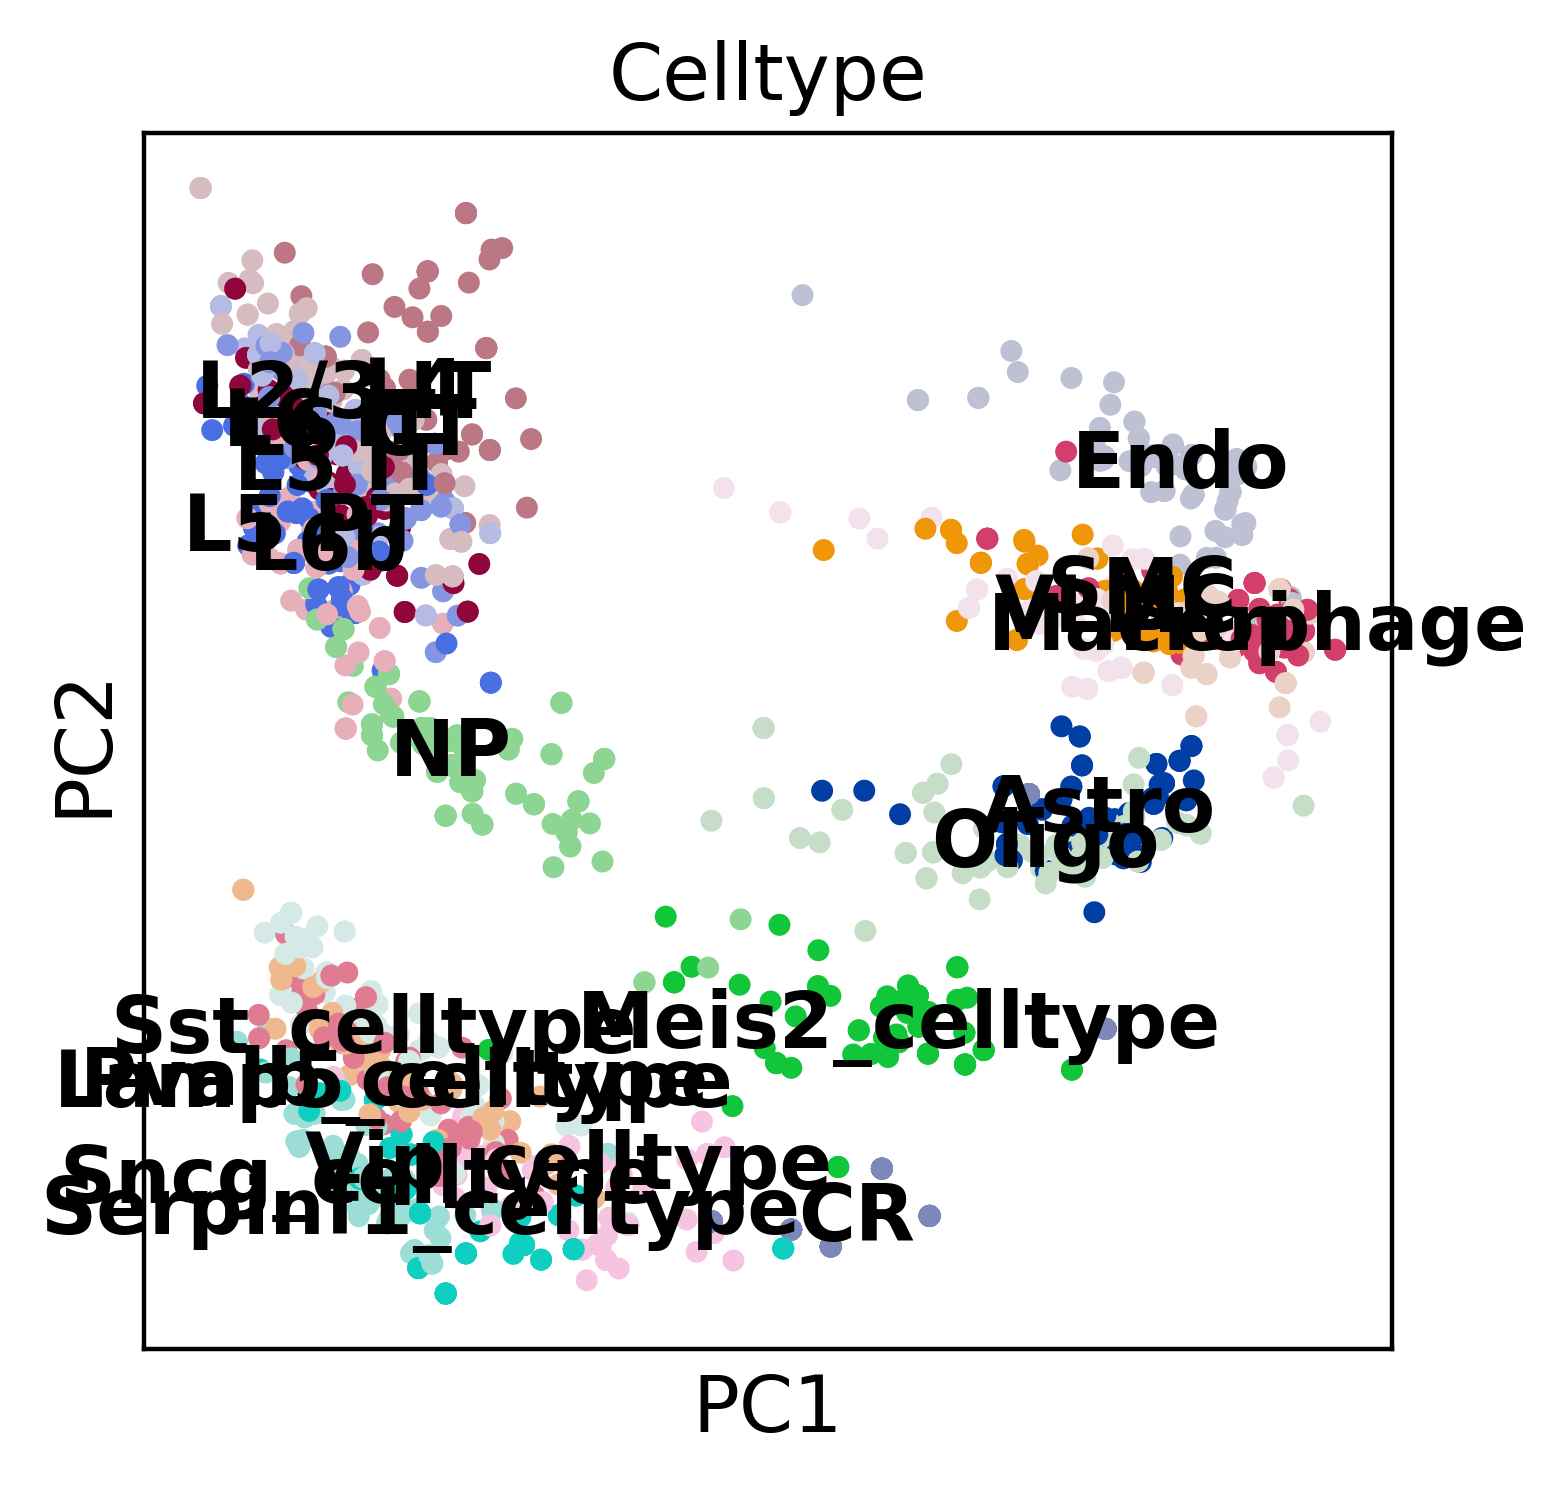

In [14]:
dissect.simulate(config)

Other steps are identical between bulk and spatial deconvolution. For those, please check the tutorial: [tutorial.ipynb](tutorial.ipynb).

-----

## Mapping cells to spots

Cells can be mapped to spots using the proportions as output by DISSECT and using them with methods such as [CytoSPACE](https://www.nature.com/articles/s41587-023-01697-9) (Vahid et al., 2023).